## 1. Configuración y carga de librerías

In [20]:
%pip install tensorflow
%pip install matplotlib
%pip install Pillow


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
# Importamos las librerías necesarias
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


## 2. Preparar las rutas y parámetros

In [22]:
# Ruta base del dataset
BASE_DIR = "COVID-19_Radiography_Dataset" 
# Subcarpetas de las clases
CLASSES = ["COVID", "NORMAL", "PNEUMONIA", "Lung_Opacity"]

# Parámetros
IMG_SIZE = (128, 128) # Tamaño al que redimensionaremos las imágenes
BATCH_SIZE = 128


Parte 3: Generadores de imágenes
Aquí configuramos los generadores de imágenes, que cargarán los datos desde las carpetas del dataset y las dividirán en conjunto de entrenamiento y validación.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,  # Dividir dataset
    rotation_range=10,     # Rotación aleatoria
    width_shift_range=0.1, # Desplazamiento horizontal
    height_shift_range=0.1, # Desplazamiento vertical
    zoom_range=0.1,        # Zoom aleatorio
    horizontal_flip=True,  # Inversión horizontal
)

train_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 33866 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.


In [24]:
import numpy as np

# Obtener etiquetas únicas y su conteo
train_labels, train_counts = np.unique(train_generator.classes, return_counts=True)
val_labels, val_counts = np.unique(val_generator.classes, return_counts=True)

# Mapeamos índices a nombres de clases
class_mapping = {v: k for k, v in train_generator.class_indices.items()}

# Mostramos los resultados
print("Distribución en el conjunto de entrenamiento:")
for label, count in zip(train_labels, train_counts):
    print(f"{class_mapping[label]}: {count} imágenes")

print("\nDistribución en el conjunto de validación:")
for label, count in zip(val_labels, val_counts):
    print(f"{class_mapping[label]}: {count} imágenes")


Distribución en el conjunto de entrenamiento:
COVID: 5786 imágenes
Lung_Opacity: 9620 imágenes
Normal: 16308 imágenes
Viral Pneumonia: 2152 imágenes

Distribución en el conjunto de validación:
COVID: 1446 imágenes
Lung_Opacity: 2404 imágenes
Normal: 4076 imágenes
Viral Pneumonia: 538 imágenes


Parte 4: Definir el modelo de CNN
En esta parte, definimos un modelo básico de red neuronal convolucional (CNN) para clasificación de imágenes.

In [29]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Modelo más ligero con regularización
model = models.Sequential([
    # Bloque 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Bloque 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Clasificador
    layers.Flatten(),
    layers.Dense(64, activation='relu'),  # Reducimos el tamaño de la capa densa
    layers.Dropout(0.3),
    layers.Dense(len(CLASSES), activation='softmax')  # Capa de salida
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Configuración de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


Usamos 3 capas convolucionales seguidas de capas de max pooling para reducir las dimensiones de las imágenes.
La capa de salida tiene softmax porque estamos haciendo clasificación multiclase (más de dos clases).
Parte 5: Entrenamiento del modelo
Ahora entrenamos el modelo utilizando los generadores que configuramos previamente. El entrenamiento se realizará por un número de épocas.

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Número máximo de épocas
    callbacks=[early_stopping]  # Callback de Early Stopping
)


TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'training_data'

In [ ]:
# Guardar el modelo en formato HDF5 (.h5)
model.save("modelo_entrenado2.h5")  
print("Modelo guardado como 'modelo_entrenado2.h5'")


Modelo guardado como 'modelo_entrenado.h5'


Parte 6: Visualización de los resultados
Una vez que el modelo haya entrenado, podemos visualizar las métricas de precisión y pérdida para evaluar el rendimiento durante el entrenamiento.

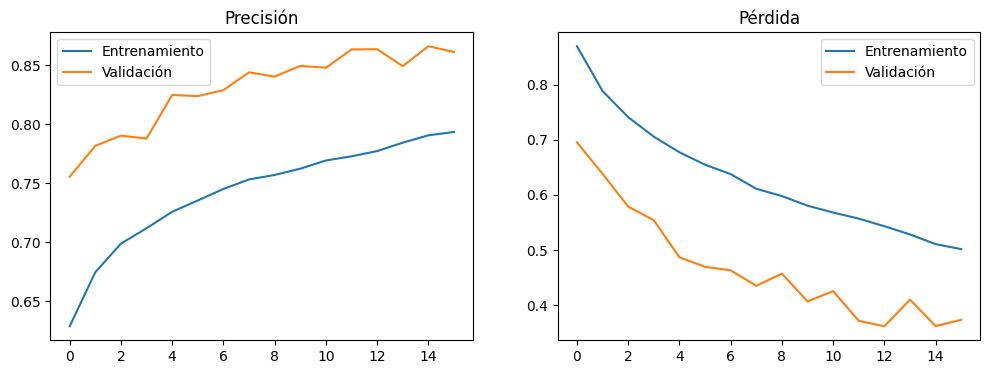

In [ ]:
# Graficar precisión y pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

plt.show()


In [ ]:
%pip install numpy
%pip install scikit-learn
%pip install seaborn
%pip install itertools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import numpy as np

# Obtener predicciones
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)  # Convertir probabilidades a clases predichas
y_true = val_generator.classes  # Etiquetas reales


67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 588ms/step


67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 620ms/step


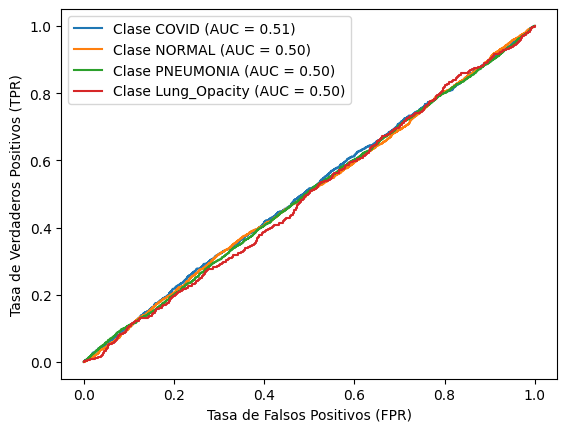

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarizar las etiquetas reales para calcular ROC por clase
y_true_binarized = label_binarize(y_true, classes=range(len(CLASSES)))
n_classes = y_true_binarized.shape[1]

# Calcular la curva ROC y el AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green", "orange"])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Clase {CLASSES[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC por clase")
plt.legend(loc="lower right")
plt.grid()
plt.show()


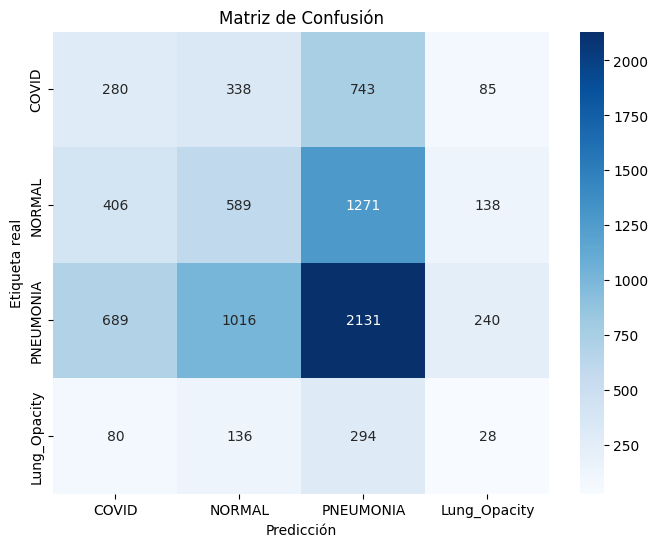

In [ ]:
import seaborn as sns

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()


In [ ]:
# Generar un reporte de clasificación
report = classification_report(y_true, y_pred, target_names=CLASSES)
print("Reporte de Clasificación:")
print(report)


Reporte de Clasificación:
              precision    recall  f1-score   support

       COVID       0.19      0.19      0.19      1446
      NORMAL       0.28      0.25      0.26      2404
   PNEUMONIA       0.48      0.52      0.50      4076
Lung_Opacity       0.06      0.05      0.05       538

    accuracy                           0.36      8464
   macro avg       0.25      0.25      0.25      8464
weighted avg       0.35      0.36      0.35      8464



In [ ]:
from sklearn.utils import resample

def compute_confidence_intervals(y_true, y_pred, class_idx, n_bootstraps=1000, confidence_level=0.95):
    """
    Calcula intervalos de confianza para la precisión de una clase específica.
    """
    precisions = []
    for _ in range(n_bootstraps):
        y_true_resampled, y_pred_resampled = resample(y_true, y_pred)
        precision = np.mean((y_pred_resampled == class_idx) & (y_true_resampled == class_idx))
        precisions.append(precision)

    lower = np.percentile(precisions, ((1 - confidence_level) / 2) * 100)
    upper = np.percentile(precisions, (1 - (1 - confidence_level) / 2) * 100)
    return lower, upper

# Calcular intervalos de confianza para cada clase
for idx, class_name in enumerate(CLASSES):
    lower, upper = compute_confidence_intervals(y_true, y_pred, class_idx=idx)
    print(f"Clase {class_name}: Precisión con 95% CI = [{lower:.3f}, {upper:.3f}]")


Clase COVID: Precisión con 95% CI = [0.029, 0.037]
Clase NORMAL: Precisión con 95% CI = [0.064, 0.075]
Clase PNEUMONIA: Precisión con 95% CI = [0.243, 0.260]
Clase Lung_Opacity: Precisión con 95% CI = [0.002, 0.005]
